In [1]:
#Natural Language Processing

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Importing the dataset
dataset = pd.read_csv('Restaurant_Reviews.tsv', sep='\t', quoting=3) #.tsv file separated by tabs, hence using sep='\t' option
dataset.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


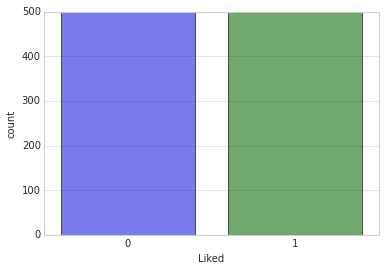

In [4]:
#Exploring a bit before the modelling
sns.set_style('whitegrid')
sns.countplot(x='Liked', data=dataset, alpha=0.6)

array([<matplotlib.axes.AxesSubplot object at 0x9d8d0e10>,
       <matplotlib.axes.AxesSubplot object at 0x9d844410>], dtype=object)

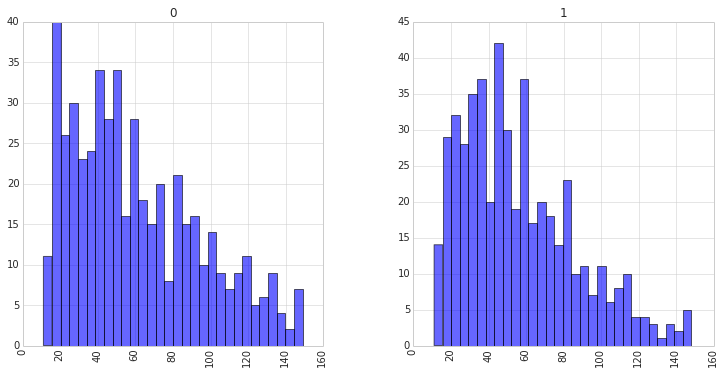

In [5]:
#Checking the length of each review separated by positive/negative review.
dataset['Length'] = dataset['Review'].apply(len)
dataset.hist(column='Length', by='Liked', bins=30, alpha=0.6, figsize=(12,6))
#Not very insightful.

In [6]:
#Cleaning the text follows. Using re and nltk package.
import re, nltk
from nltk.corpus import stopwords
#Stemming to get only the 'root' word. Ex: loved->love. Still positive, reduced number of words to analyze.
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [7]:
#Creating the function to clean the reviews. Could just put txt directly in, but already had it written.
def textcln(txt):
    #Using 'set()' is much faster for large text sets, '[^a-zA-Z]' keeps only characters in upper/lowercase a-z.
    rev_text = txt
    review = [ps.stem(word) for word in re.sub('[^a-zA-Z]', ' ', rev_text).lower().split() if not word in set(stopwords.words('english'))]
    #Rejoining the list to get a single string again
    review = ' '.join(review)
    return review

#Note, this could all be done with one line:
##review = ' '.join([ps.stem(word) for word in re.sub('[^a-zA-Z]', ' ', rev_text).lower().split() if not word in set(stopwords.words('english'))])
#Does look a little messy/unclear what is going on.

In [8]:
dataset['Corpus'] = dataset['Review'].apply(lambda txt: textcln(txt))

In [9]:
#Creating the 'bag-of-words' model
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(dataset['Corpus']).toarray()
y = dataset['Liked']
X.shape

/usr/lib/python3/dist-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:
/usr/lib/python3/dist-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


(1000, 1500)

In [11]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[72 25]
 [22 81]]
0.765


/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/lib/python3/dist-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:
/usr/lib/python3/dist-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) !=

In [12]:
#Doing the same thing with logistic regression
from sklearn.linear_model import LogisticRegression
log_reg_classifier = LogisticRegression(random_state=0)
log_reg_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
lr_y_pred = log_reg_classifier.predict(X_test)

In [14]:
lr_cm = confusion_matrix(y_test, lr_y_pred)
print(lr_cm)
print(accuracy_score(y_test, lr_y_pred))

[[76 21]
 [37 66]]
0.71


/usr/lib/python3/dist-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


In [15]:
#Trying to check the most important words for the positive/negative review classificatons
#Grab all the coefficients of the classifier
coefs = log_reg_classifier.coef_[0]
#Grab all the words in the bag-of-words representation (same order as coefficients)
vocab = cv.get_feature_names()
#Create dataframe of just words and coefficients
word_coefs = pd.DataFrame(index=np.arange(0,1500))
word_coefs['Words'] = vocab
word_coefs['Coefs'] = coefs
#Grab the top 10 and bottom 10
top5 = word_coefs.nlargest(10, 'Coefs')
low5 = word_coefs.nsmallest(10, 'Coefs')

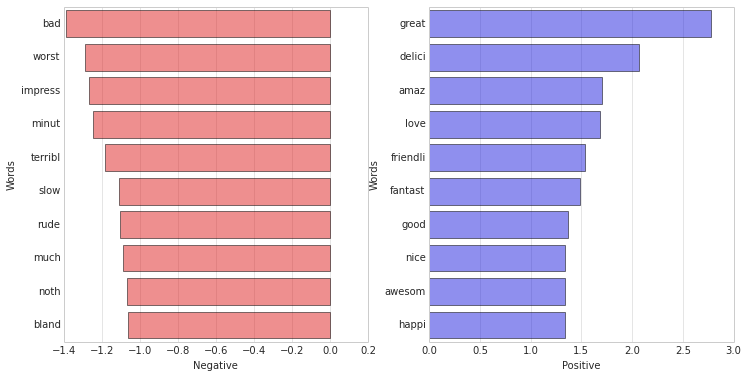

In [16]:
#Creating a plot to compare the words and their effect.
#Make a subplot figure
fig, (ax1, ax2) = plt.subplots(ncols=2)
#Creat the two axes-level barplots, and project them onto the axes of the figure
sns.barplot(x='Coefs', y='Words', data=top5, alpha=0.5, color='blue', ax=ax2)
sns.barplot(x='Coefs', y='Words', data=low5, alpha=0.5, color='red', ax=ax1)
#Figure options
fig.set_size_inches(12,6)
ax1.set_xlabel('Negative')
ax2.set_xlabel('Positive')

In [17]:
#Trying to improve the model using TFIDF
from sklearn.feature_extraction.text import TfidfTransformer
#Fit the transformer to the existing BOW representation of the reviews
tfidf_transformer = TfidfTransformer().fit(X)

/usr/lib/python3/dist-packages/scipy/sparse/coo.py:182: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(M) != 2:
/usr/lib/python3/dist-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:
/usr/lib/python3/dist-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:


In [18]:
#Transform the existing BOW using the tfidf transformer
X_tfidf = tfidf_transformer.transform(X)
X_tfidf.shape

/usr/lib/python3/dist-packages/scipy/sparse/coo.py:182: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(M) != 2:
/usr/lib/python3/dist-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:
/usr/lib/python3/dist-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:


(1000, 1500)

In [19]:
#Check if this has helped logistic regression at all
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.20, random_state = 0)

from sklearn.linear_model import LogisticRegression
tfidflog_reg_classifier = LogisticRegression(random_state=0)
tfidflog_reg_classifier.fit(X_train, y_train)

tfidflr_y_pred = tfidflog_reg_classifier.predict(X_test)

tfidflr_cm = confusion_matrix(y_test, tfidflr_y_pred)
print(tfidflr_cm)
print(accuracy_score(y_test, tfidflr_y_pred))

[[85 12]
 [37 66]]
0.755


/usr/lib/python3/dist-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:
/usr/lib/python3/dist-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


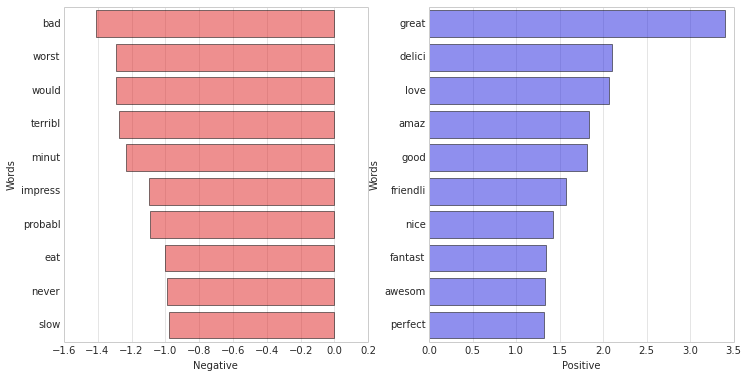

In [20]:
#Can see a slight improvement, from 71% to 75.5%. Has this changed the words we fit to?
#All work is the same as above before TFIDF was applied.
tfidf_coefs = tfidflog_reg_classifier.coef_[0]
vocab = cv.get_feature_names()
tfidf_word_coefs = pd.DataFrame(index=np.arange(0,1500))
tfidf_word_coefs['Words'] = vocab
tfidf_word_coefs['Coefs'] = tfidf_coefs
tfidf_top5 = tfidf_word_coefs.nlargest(10, 'Coefs')
tfidf_low5 = tfidf_word_coefs.nsmallest(10, 'Coefs')

#Creating a plot to compare the words and their effect.
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.barplot(x='Coefs', y='Words', data=tfidf_top5, alpha=0.5, color='blue', ax=ax2)
sns.barplot(x='Coefs', y='Words', data=tfidf_low5, alpha=0.5, color='red', ax=ax1)
fig.set_size_inches(12,6)
ax1.set_xlabel('Negative')
ax2.set_xlabel('Positive')

In [21]:
# Fitting Naive Bayes to the new training set after TFIDF was applied.
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[73 24]
 [21 82]]
0.775
             precision    recall  f1-score   support

          0       0.78      0.75      0.76        97
          1       0.77      0.80      0.78       103

avg / total       0.78      0.78      0.77       200



/usr/lib/python3/dist-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:
/usr/lib/python3/dist-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


In [57]:
#Also a very small improvement. Fairly even split between type-I and type-II errors.

In [110]:
#Trying to visualize using PCA. Code is assuming CV has been done
X = cv.fit_transform(dataset['Corpus']).toarray()
y = dataset['Liked']

/usr/lib/python3/dist-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:
/usr/lib/python3/dist-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


In [111]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.02454913, 0.02116401])

/usr/local/lib/python3.4/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


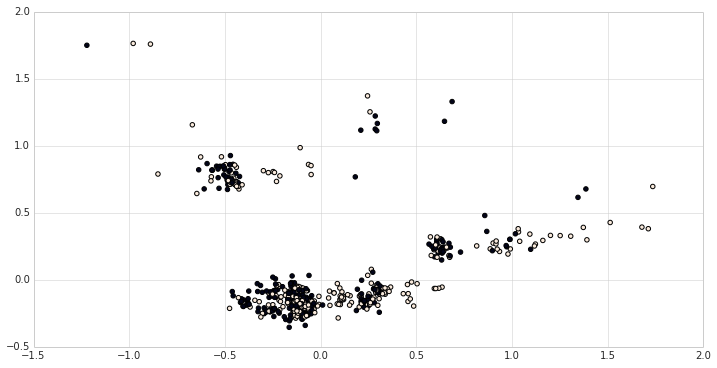

In [112]:
#Separating the classification based on the top 2 principal components. Not a very good separation.
PC1 = X_train[:,0].tolist()
PC2 = X_train[:,1].tolist()
plt.figure(figsize=(12,6))
plt.scatter(x=PC1, y=PC2, c=y_train)